## 필요한 모듈 설치 확인

In [1]:
!git clone https://github.com/openai/baselines.git

Cloning into 'baselines'...
remote: Enumerating objects: 3627, done.
remote: Total 3627 (delta 0), reused 0 (delta 0), pack-reused 3627
Receiving objects: 100% (3627/3627), 6.46 MiB | 30.21 MiB/s, done.
Resolving deltas: 100% (2429/2429), done.


In [2]:
import gym
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.autograd as autograd
import numpy as np

import random
import os
import pickle
import time
from collections import deque
from tqdm import tqdm

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
sns.set()

import sys
sys.path.insert(0, 'baselines')

from baselines.common import atari_wrappers as wrappers
from baselines.common.cmd_util import make_vec_env
from baselines.common import runners
import multiprocessing as mp
from baselines.common.vec_env import SubprocVecEnv
import cv2

## Wrappers

In [3]:
class NoopResetEnv(gym.Wrapper):
    def __init__(self, env, noop_max=30):
        """Sample initial states by taking random number of no-ops on reset.
        No-op is assumed to be action 0.
        """
        gym.Wrapper.__init__(self, env)
        self.noop_max = noop_max
        self.override_num_noops = None
        self.noop_action = 0
        assert env.unwrapped.get_action_meanings()[0] == 'NOOP'

    def reset(self, **kwargs):
        """ Do no-op action for a number of steps in [1, noop_max]."""
        self.env.reset(**kwargs)
        if self.override_num_noops is not None:
            noops = self.override_num_noops
        else:
            noops = self.unwrapped.np_random.randint(1, self.noop_max + 1) #pylint: disable=E1101
        assert noops > 0
        obs = None
        for _ in range(noops):
            obs, _, done, _ = self.env.step(self.noop_action)
            if done:
                obs = self.env.reset(**kwargs)
        return obs

    def step(self, ac):
        return self.env.step(ac)

class FireResetEnv(gym.Wrapper):
    def __init__(self, env):
        """Take action on reset for environments that are fixed until firing."""
        gym.Wrapper.__init__(self, env)
        assert env.unwrapped.get_action_meanings()[1] == 'FIRE'
        assert len(env.unwrapped.get_action_meanings()) >= 3

    def reset(self, **kwargs):
        self.env.reset(**kwargs)
        obs, _, done, _ = self.env.step(1)
        if done:
            self.env.reset(**kwargs)
        obs, _, done, _ = self.env.step(2)
        if done:
            self.env.reset(**kwargs)
        return obs

    def step(self, ac):
        return self.env.step(ac)

class EpisodicLifeEnv(gym.Wrapper):
    def __init__(self, env):
        """Make end-of-life == end-of-episode, but only reset on true game over.
        Done by DeepMind for the DQN and co. since it helps value estimation.
        """
        gym.Wrapper.__init__(self, env)
        self.lives = 0
        self.was_real_done  = True

    def step(self, action):
        obs, reward, done, info = self.env.step(action)
        self.was_real_done = done
        # check current lives, make loss of life terminal,
        # then update lives to handle bonus lives
        lives = self.env.unwrapped.ale.lives()
        if lives < self.lives and lives > 0:
            # for Qbert sometimes we stay in lives == 0 condition for a few frames
            # so it's important to keep lives > 0, so that we only reset once
            # the environment advertises done.
            done = True
        self.lives = lives
        return obs, reward, done, info

    def reset(self, **kwargs):
        """Reset only when lives are exhausted.
        This way all states are still reachable even though lives are episodic,
        and the learner need not know about any of this behind-the-scenes.
        """
        if self.was_real_done:
            obs = self.env.reset(**kwargs)
        else:
            # no-op step to advance from terminal/lost life state
            obs, _, _, _ = self.env.step(0)
        self.lives = self.env.unwrapped.ale.lives()
        return obs

class MaxAndSkipEnv(gym.Wrapper):
    def __init__(self, env, skip=4):
        """Return only every `skip`-th frame"""
        gym.Wrapper.__init__(self, env)
        # most recent raw observations (for max pooling across time steps)
        self._obs_buffer = np.zeros((2,)+env.observation_space.shape, dtype=np.uint8)
        self._skip       = skip

    def step(self, action):
        """Repeat action, sum reward, and max over last observations."""
        total_reward = 0.0
        done = None
        for i in range(self._skip):
            obs, reward, done, info = self.env.step(action)
            if i == self._skip - 2: self._obs_buffer[0] = obs
            if i == self._skip - 1: self._obs_buffer[1] = obs
            total_reward += reward
            if done:
                break
        # Note that the observation on the done=True frame
        # doesn't matter
        max_frame = self._obs_buffer.max(axis=0)

        return max_frame, total_reward, done, info

    def reset(self, **kwargs):
        return self.env.reset(**kwargs)

class ClipRewardEnv(gym.RewardWrapper):
    def __init__(self, env):
        gym.RewardWrapper.__init__(self, env)

    def reward(self, reward):
        """Bin reward to {+1, 0, -1} by its sign."""
        return np.sign(reward)


class WarpFrame(gym.ObservationWrapper):
    def __init__(self, env, width=84, height=84, grayscale=True, dict_space_key=None):
        """
        Warp frames to 84x84 as done in the Nature paper and later work.
        If the environment uses dictionary observations, `dict_space_key` can be specified which indicates which
        observation should be warped.
        """
        super().__init__(env)
        self._width = width
        self._height = height
        self._grayscale = grayscale
        self._key = dict_space_key
        if self._grayscale:
            num_colors = 1
        else:
            num_colors = 3

        new_space = gym.spaces.Box(
            low=0,
            high=255,
            shape=(self._height, self._width, num_colors),
            dtype=np.uint8,
        )
        if self._key is None:
            original_space = self.observation_space
            self.observation_space = new_space
        else:
            original_space = self.observation_space.spaces[self._key]
            self.observation_space.spaces[self._key] = new_space
        assert original_space.dtype == np.uint8 and len(original_space.shape) == 3

    def observation(self, obs):
        if self._key is None:
            frame = obs
        else:
            frame = obs[self._key]

        if self._grayscale:
            frame = cv2.cvtColor(frame, cv2.COLOR_RGB2GRAY)
        frame = cv2.resize(
            frame, (self._width, self._height), interpolation=cv2.INTER_AREA
        )
        if self._grayscale:
            frame = np.expand_dims(frame, -1)

        if self._key is None:
            obs = frame
        else:
            obs = obs.copy()
            obs[self._key] = frame
        return obs

class ImageToPyTorch(gym.ObservationWrapper):
    """
    Change image shape to CWH
    """
    def __init__(self, env):
        super(ImageToPyTorch, self).__init__(env)
        old_shape = self.observation_space.shape
        self.observation_space = gym.spaces.Box(low=0.0, high=1.0, shape=(old_shape[-1], old_shape[0], old_shape[1]))

    def observation(self, observation):
        return np.swapaxes(observation, 2, 0)

class FrameStack(gym.Wrapper):
    def __init__(self, env, k):
        """Stack k last frames.
        Returns lazy array, which is much more memory efficient.
        See Also
        --------
        baselines.common.atari_wrappers.LazyFrames
        """
        gym.Wrapper.__init__(self, env)
        self.k = k
        self.frames = deque([], maxlen=k)
        shp = env.observation_space.shape
        self.observation_space = gym.spaces.Box(low=0, high=255, shape=(shp[:-1] + (shp[-1] * k,)), dtype=env.observation_space.dtype)

    def reset(self):
        ob = self.env.reset()
        for _ in range(self.k):
            self.frames.append(ob)
        return self._get_ob()

    def step(self, action):
        ob, reward, done, info = self.env.step(action)
        self.frames.append(ob)
        return self._get_ob(), reward, done, info

    def _get_ob(self):
        assert len(self.frames) == self.k
        return LazyFrames(list(self.frames))

class ScaledFloatFrame(gym.ObservationWrapper):
    def __init__(self, env):
        gym.ObservationWrapper.__init__(self, env)
        self.observation_space = gym.spaces.Box(low=0, high=1, shape=env.observation_space.shape, dtype=np.float32)

    def observation(self, observation):
        # careful! This undoes the memory optimization, use
        # with smaller replay buffers only.
        return np.array(observation).astype(np.float32) / 255.0

class LazyFrames(object):
    def __init__(self, frames):
        """This object ensures that common frames between the observations are only stored once.
        It exists purely to optimize memory usage which can be huge for DQN's 1M frames replay
        buffers.
        This object should only be converted to numpy array before being passed to the model.
        You'd not believe how complex the previous solution was."""
        self._frames = frames
        self._out = None

    def _force(self):
        if self._out is None:
            self._out = np.concatenate(self._frames, axis=-1)
            self._frames = None
        return self._out

    def __array__(self, dtype=None):
        out = self._force()
        if dtype is not None:
            out = out.astype(dtype)
        return out

    def __len__(self):
        return len(self._force())

    def __getitem__(self, i):
        return self._force()[i]

    def count(self):
        frames = self._force()
        return frames.shape[frames.ndim - 1]

    def frame(self, i):
        return self._force()[..., i]

def make_atari(env_id, max_episode_steps=None):
    env = gym.make(env_id)
    assert 'NoFrameskip' in env.spec.id
    env = NoopResetEnv(env, noop_max=30)
    env = MaxAndSkipEnv(env, skip=4)
    if max_episode_steps is not None:
        env = TimeLimit(env, max_episode_steps=max_episode_steps)
    return env

def wrap_deepmind(env, episode_life=True, clip_rewards=True, frame_stack=True, scale=False):
    """Configure environment for DeepMind-style Atari.
    """
    if episode_life:
        env = EpisodicLifeEnv(env)
    if 'FIRE' in env.unwrapped.get_action_meanings():
        env = FireResetEnv(env)
    env = WarpFrame(env)
    if scale:
        env = ScaledFloatFrame(env)
    if clip_rewards:
        env = ClipRewardEnv(env)
    if frame_stack:
        env = FrameStack(env, 4)
    return ImageToPyTorch(env)

In [4]:
from baselines.common.vec_env.dummy_vec_env import DummyVecEnv

## 하이퍼 파라미터 정의하기

In [5]:
'PPO Settings'''
TRAJ_LEN = 128
N_OPT_EPOCHS = 10
ENT_COEF = 1e-2
CLIP_RANGE = 0.1
LAMBDA = 0.95

'''RND Settings'''
# RND start step for input normalization
RND_START = int(0)
# Discount rate for intrinsic reward
INT_GAMMA = 0.99

'''Environment Settings'''
# sequential images to define state
STATE_LEN = 4
# openai gym env name
ENV_NAME = 'BreakoutNoFrameskip-v4'
# number of environments for A2C
N_ENVS = 4
# define gym 
# env = make_vec_env(ENV_NAME, env_type = "atari",  num_env = N_ENVS, seed = None)
env = DummyVecEnv([lambda: wrap_deepmind(make_atari(ENV_NAME)) for i in range(N_ENVS)])

# check gym setting
N_ACTIONS = env.action_space.n;print('N_ACTIONS : ',N_ACTIONS) #  6
N_STATES = env.observation_space.shape;print('N_STATES : ',N_STATES) # (4, 84, 84)
# Total simulation step
N_STEP = int(1e+7)
# gamma for MDP
GAMMA = 0.9999
# visualize for agent playing
RENDERING = False

'''Training settings'''
# check GPU usage
USE_GPU = torch.cuda.is_available()
print('USE GPU: '+str(USE_GPU))
# mini-batch size
BATCH_SIZE = 128
# learning rage
LR = 1e-4
# clip gradient
MAX_GRAD_NORM = 0.1
# log optimization
LOG_OPT = False

'''Save&Load Settings'''
# log frequency
LOG_FREQ = 10
# check save/load
SAVE = False
LOAD = False
# paths for predction net, target net, result log
NET_PATH = './data/model/ppo_net.pkl'
PRED_PATH = './data/model/pred_net.pkl'

N_ACTIONS :  4
N_STATES :  (4, 84, 84)
USE GPU: True


## 네트워크 구조 정의하기

In [6]:
class ConvNet(nn.Module):
    def __init__(self):
        super(ConvNet, self).__init__()
        # architecture def
        self.feature_extraction = nn.Sequential(
            nn.Conv2d(STATE_LEN, 32, kernel_size=8, stride=4),
            nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=4, stride=2),
            nn.ReLU(),
            nn.Conv2d(64, 64, kernel_size=3, stride=1)
        )
        self.fc1 = nn.Linear(7 * 7 * 64, 256)
        self.fc2 = nn.Linear(256, 256)
        # actor
        self.actor = nn.Linear(256, N_ACTIONS)
        # extrinsic critic
        self.critic = nn.Linear(256, 1)
        # intrinsic critic
        self.int_critic = nn.Linear(256, 1)
            
        # parameter initialization
        for m in self.modules():
            if isinstance(m, nn.Conv2d) or isinstance(m, nn.Linear):
                nn.init.orthogonal_(m.weight, gain = np.sqrt(2))
                nn.init.constant_(m.bias, 0.0)



    def forward(self, x):
        # x is a tensor of (m, 4, 84, 84)
        x = self.feature_extraction(x / 255.0)
        # x.size(0) : mini-batch size
        x = x.view(x.size(0), -1)
        x = self.fc1(F.relu(x))
        x = self.fc2(F.relu(x))
        # use log_softmax for numerical stability
        action_log_prob = F.log_softmax(self.actor(F.relu(x)), dim=1)
        state_value = self.critic(F.relu(x))
        int_state_value = self.int_critic(F.relu(x))

        return action_log_prob, state_value, int_state_value

    def save(self, PATH):
        torch.save(self.state_dict(),PATH)

    def load(self, PATH):
        self.load_state_dict(torch.load(PATH))
        
class RandomPredNet(nn.Module):
    def __init__(self):
        super(RandomPredNet, self).__init__()
        # architecture def
        self.feature_extraction = nn.Sequential(
            nn.Conv2d(4, 32, kernel_size=8, stride=4),
            nn.LeakyReLU(negative_slope=2e-1),
            nn.Conv2d(32, 64, kernel_size=4, stride=2),
            nn.LeakyReLU(negative_slope=2e-1),
            nn.Conv2d(64, 64, kernel_size=3, stride=1)
        )
        self.fc1 = nn.Linear(7 * 7 * 64, 256)
        # one more layer than target network for enough capacity
        self.fc2 = nn.Linear(256, 256)
        
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.orthogonal_(m.weight, gain = np.sqrt(2))
                nn.init.constant_(m.bias, 0.0)
            elif isinstance(m, nn.Linear):
                nn.init.kaiming_normal_(m.weight)
                nn.init.constant_(m.bias, 0.0)
            

    def forward(self, x):
        # if you use feature normalization in RND, remove division by 255.0
        x = self.feature_extraction(x / 255.0)
        # x.size(0) : mini-batch size
        x = x.view(x.size(0), -1)
        x = self.fc1(F.leaky_relu(x, negative_slope=2e-1))
        x = self.fc2(F.leaky_relu(x, negative_slope=2e-1))
        return x
    
    def save(self, PATH):
        torch.save(self.state_dict(),PATH)

    def load(self, PATH):
        self.load_state_dict(torch.load(PATH))
        
class RandomTargetNet(nn.Module):
    def __init__(self):
        super(RandomTargetNet, self).__init__()
        # architecture def
        self.feature_extraction = nn.Sequential(
            nn.Conv2d(4, 32, kernel_size=8, stride=4),
            nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=4, stride=2),
            nn.ReLU(),
            nn.Conv2d(64, 64, kernel_size=3, stride=1),
        )
        self.fc1 = nn.Linear(7 * 7 * 64, 256)
        
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.orthogonal_(m.weight, gain = np.sqrt(2))
                nn.init.constant_(m.bias, 0.0)
            elif isinstance(m, nn.Linear):
                nn.init.kaiming_normal_(m.weight)
                nn.init.constant_(m.bias, 0.0)

    def forward(self, x):
        # if you use feature normalization in RND, remove division by 255.0
        x = self.feature_extraction(x / 255.0)
        # x.size(0) : mini-batch size
        x = x.view(x.size(0), -1)
        x = self.fc1(F.relu(x))
        return x

## RND 정의하기

In [7]:
class PPO:
    def __init__(self):
        self.net = ConvNet()
        self.rand_target = RandomTargetNet()
        self.rand_pred = RandomPredNet()
        # use gpu
        if USE_GPU:
            self.net = self.net.cuda()
            self.rand_target = self.rand_target.cuda()
            self.rand_pred = self.rand_pred.cuda()
            
        # simulator step conter
        self.memory_counter = 0
        
        # define optimizer
        self.optimizer = torch.optim.Adam(self.net.parameters(), lr=LR)
        # define optimizer for predict network
        self.rand_pred_opt = torch.optim.Adam(self.rand_pred.parameters(), lr=LR)
        
        # ppo clip range
        self.clip_range = CLIP_RANGE
        
        # observation statistics for RND (if you use feature normalization in RND)
        self.s_mu = None
        self.s_sigma = None
        
    def save_model(self):
        self.net.cpu()
        self.rand_pred.cpu()
        
        self.net.save(NET_PATH)
        self.rand_pred.save(PRED_PATH)
        if USE_GPU:
            self.net.cuda()
            self.rand_pred.cuda()
            
    def load_model(self):
        self.net.cpu()
        self.rand_pred.cpu()
        
        self.net.load(NET_PATH)
        self.rand_pred.load(PRED_PATH)
        if USE_GPU:
            self.net.cuda()
            self.rand_pred.cuda()
        
    def choose_action(self, x):
        self.memory_counter += 1
        # Assume that x is a np.array of shape (nenvs, 4, 84, 84)
        x = torch.FloatTensor(x)
        if USE_GPU:
            x = x.cuda()
        # get action log probs and state values
        action_log_probs, state_values, int_state_values = self.net(x) # (nenvs, N_ACTIONS)
        probs = F.softmax(action_log_probs, dim=1).data.cpu().numpy()
        # sample actions
        actions = np.array([np.random.choice(N_ACTIONS,p=probs[i]) for i in range(len(probs))])
        # convert tensor to np.array
        action_log_probs = action_log_probs.data.cpu().numpy()
        state_values = state_values.squeeze(1).data.cpu().numpy()
        int_state_values = int_state_values.squeeze(1).data.cpu().numpy()
        # calc selected logprob
        selected_log_probs = np.array([action_log_probs[i][actions[i]] for i in range(len(probs))])
        return actions, state_values, int_state_values, selected_log_probs
    
    def r_int(self, s):
        s = torch.FloatTensor(s)
        # feature normalization part in RND
        # get intrinsic reward
#         r_input = list()
#         for i in range(len(s)):
#             r_input.append((s[i, -1] - self.s_mu)/(self.s_sigma + 1e-8))
#         s = torch.clamp(torch.FloatTensor(r_input).unsqueeze(1), -5., 5.) # (N_ENVS, 1, 84, 84)
        if USE_GPU:
            s = s.cuda()
        r_target = self.rand_target(s) # (N_ENVS, 256)
        r_pred = self.rand_pred(s) # (N_ENVS, 256)
        r_int = torch.mean(F.mse_loss(r_target, r_pred, reduction='none'), dim=1)
        
        return r_int.data.cpu().numpy()
    
    def learn_predict(self, s):
        s = torch.FloatTensor(s)
        # feature normalization part in RND
        # RND pred net optimize
#         r_input = list()
#         for i in range(len(s)):
#             r_input.append((obs[i, -1] - self.s_mu)/(self.s_sigma + 1e-8))
#         s = torch.clamp(torch.FloatTensor(r_input).unsqueeze(1), -5., 5.) # (N_ENVS, 1, 84, 84)
        if USE_GPU:
            s = s.cuda()
        s.requires_grad = True
        r_target = self.rand_target(s) # (N_ENVS, 256)
        r_pred = self.rand_pred(s) # (N_ENVS, 256)
        r_int = torch.mean(F.mse_loss(r_pred, r_target, reduction='none'), dim=1)
        # (N_ENVS)
        # zero-centered gradient penalty for vanishing gradient problem. You can remove this part
        # check https://arxiv.org/abs/1801.04406 for more information.
        grad = autograd.grad(r_int, s, create_graph=True,
                        grad_outputs=torch.ones_like(r_int),
                        retain_graph=True, only_inputs=True)[0].view(len(s), -1)
        grad = grad.norm(dim=1)
        loss = r_int.mean() + 100.0 * ((grad)**2).mean()
        
        self.rand_pred_opt.zero_grad()
        loss.backward()
        nn.utils.clip_grad_norm_(self.rand_pred.parameters(), MAX_GRAD_NORM)
        self.rand_pred_opt.step()
        return r_int.data.cpu().numpy()

    def learn(self, obs, returns, int_returns, masks, actions, values, int_values,  selected_log_probs):
        # np.array -> torch.Tensor
        obs = torch.FloatTensor(obs) # (m, 4, 84, 84)
        returns = torch.FloatTensor(returns) # (m)
        int_returns = torch.FloatTensor(int_returns) # (m)
        actions = torch.LongTensor(actions) # (m)
        selected_log_probs = torch.FloatTensor(selected_log_probs) # (m)
        values = torch.FloatTensor(values) # (m)
        int_values = torch.FloatTensor(int_values) # (m)
        if USE_GPU:
            obs = obs.cuda()
            returns = returns.cuda()
            int_returns = int_returns.cuda()
            actions = actions.cuda()
            selected_log_probs = selected_log_probs.cuda()
            values = values.cuda()
            int_values = int_values.cuda()
        
        # get action log probs and state values
        action_log_probs, state_values, int_state_values = self.net(obs)
        # (m, N_ACTIONS), (m, 1)
        
        # calculate the advantages
        # original RND
#         advs = 2 * (returns - values) + (int_returns - int_values)
        # only intrinsic motivation agent's advantage
        advs = (int_returns - int_values)
        advs = (advs - advs.mean())/(advs.std() + 1e-8)
        
        # calc probs
        probs = F.softmax(action_log_probs, dim=1)
        # (m, N_ACTIONS)
        
        # calc entropy loss
        ent_loss = ENT_COEF *((action_log_probs * probs).sum(dim=1)).mean()
        # (1)
        
        # calc log probs
        cur_log_probs = action_log_probs.gather(1,actions.unsqueeze(1))
        # cur : (m, 1)
        ratio = torch.exp(cur_log_probs.squeeze(1)-selected_log_probs)
        # (m)
        
        # actor loss
        surr1 = ratio * advs # (m)
        surr2 = torch.clamp(ratio, 1.0 - self.clip_range, 1.0 + self.clip_range)*advs # (m)
        actor_loss = -torch.min(surr1, surr2).mean() # (1)
        # critic loss
        critic_loss = F.smooth_l1_loss(state_values.squeeze(1), returns) # (1)
        # int critic loss
        int_critic_loss = F.smooth_l1_loss(int_state_values.squeeze(1), int_returns) # (1)

        loss = actor_loss + critic_loss + ent_loss + int_critic_loss # (1)
        
        actor_loss, critic_loss, ent_loss, total_loss = actor_loss.data.cpu().numpy(), \
        critic_loss.data.cpu().numpy(), ent_loss.data.cpu().numpy(), loss.data.cpu().numpy()

        self.optimizer.zero_grad()
        loss.backward()
        nn.utils.clip_grad_norm_(self.net.parameters(), MAX_GRAD_NORM)
        self.optimizer.step()
        
        return round(float(actor_loss), 4), round(float(critic_loss), 4),\
    round(float(ent_loss), 4), round(float(total_loss), 4)

In [8]:
from abc import ABC, abstractmethod

class AbstractEnvRunner(ABC):
    def __init__(self, *, env, model, nsteps):
        self.env = env
        self.model = model
        self.nenv = nenv = env.num_envs if hasattr(env, 'num_envs') else 1
        self.batch_ob_shape = (nenv*nsteps,) + env.observation_space.shape
        self.obs = np.zeros((nenv,) + env.observation_space.shape, dtype=env.observation_space.dtype.name)
        self.obs[:] = env.reset()
        self.nsteps = nsteps
        self.dones = [False for _ in range(nenv)]

    @abstractmethod
    def run(self):
        raise NotImplementedError

class Runner(AbstractEnvRunner):
    """
    We use this object to make a mini batch of experiences
    __init__:
    - Initialize the runner
    run():
    - Make a mini batch
    """
    def __init__(self, *, env, model, nsteps, gamma, int_gamma, lam, rnd_start=int(1e+3)):
        super().__init__(env=env, model=model, nsteps=nsteps)
        # Lambda used in GAE (General Advantage Estimation)
        self.lam = lam
        # Discount rate
        self.gamma = gamma
        self.int_gamma = int_gamma
        self.rnd_start = rnd_start
        self.s_arr = list()

    def run(self):
        # Here, we init the lists that will contain the mb of experiences
        mb_obs, mb_rewards, mb_int_rewards, mb_actions, mb_values, mb_int_values, mb_dones, mb_neglogpacs = [],[],[],[],[],[], [], []
        epinfos = []
        # For n in range number of steps
        for _ in range(self.nsteps):
            # Given observations, get action value and neglopacs
            # We already have self.obs because Runner superclass run self.obs[:] = env.reset() on init
            actions, values, int_values, neglogpacs = self.model.choose_action(self.obs)
            mb_obs.append(self.obs.copy())
            mb_actions.append(actions)
            mb_values.append(values)
            mb_int_values.append(int_values)
            mb_neglogpacs.append(neglogpacs)
            mb_dones.append(self.dones)

            # Take actions in env and look the results
            # Infos contains a ton of useful informations
            self.obs[:], rewards, self.dones, infos = self.env.step(actions)

            if self.model.memory_counter < self.rnd_start:
                # RND state data gather
                for i in range(len(self.obs)):
                    # RND uses only last image
                    self.s_arr.append(self.obs[i, -1])
                r_int = np.zeros_like(rewards)
            elif self.model.memory_counter == self.rnd_start:
                print("RND STAT FINISH")
                # calc state stat
                self.model.s_mu = np.mean(self.s_arr, axis=0)
                self.model.s_sigma = np.std(self.s_arr, axis=0)
                r_int = np.zeros_like(rewards)
            else:
                # get intrinsic reward
                r_int = self.model.r_int(self.obs)
                    
                   
            mb_rewards.append(rewards)
            mb_int_rewards.append(r_int)
        #batch of steps to batch of rollouts
        mb_obs = np.asarray(mb_obs, dtype=self.obs.dtype)
        mb_rewards = np.asarray(mb_rewards, dtype=np.float32)
        mb_int_rewards = np.asarray(mb_int_rewards, dtype=np.float32)
        mb_actions = np.asarray(mb_actions)
        mb_values = np.asarray(mb_values, dtype=np.float32)
        mb_int_values = np.asarray(mb_int_values, dtype=np.float32)
        mb_neglogpacs = np.asarray(mb_neglogpacs, dtype=np.float32)
        mb_dones = np.asarray(mb_dones, dtype=np.bool)
        
        # post processing of intrinsic rewards
        mb_int_rewards = mb_int_rewards / (np.std(mb_int_values) + 1e-8)
        
        # choose action then we get (actions, values, log_probs)
        last_values = self.model.choose_action(self.obs)[1]
        last_int_values = self.model.choose_action(self.obs)[2]

        # discount/bootstrap off value fn
        mb_returns = np.zeros_like(mb_rewards)
        mb_advs = np.zeros_like(mb_rewards)
        lastgaelam = 0
        
        mb_int_returns = np.zeros_like(mb_int_rewards)
        mb_int_advs = np.zeros_like(mb_int_rewards)
        int_lastgaelam = 0
        
        for t in reversed(range(self.nsteps)):
            
            if t == self.nsteps - 1:
                nextnonterminal = 1.0 - self.dones
                nextvalues = last_values
                next_intvalues = last_int_values
            else:
                nextnonterminal = 1.0 - mb_dones[t+1]
                nextvalues = mb_values[t+1]
                next_intvalues = mb_int_values[t+1]
                
            delta = mb_rewards[t] + self.gamma * nextvalues * nextnonterminal - mb_values[t]
            mb_advs[t] = lastgaelam = delta + self.gamma * self.lam * nextnonterminal * lastgaelam
            
            int_delta = mb_int_rewards[t] + self.int_gamma * next_intvalues * nextnonterminal - mb_int_values[t]
            mb_int_advs[t] = int_lastgaelam = int_delta + self.int_gamma * self.lam * nextnonterminal * int_lastgaelam
        
        mb_returns = mb_advs + mb_values
        mb_int_returns = mb_int_advs + mb_int_values


        return (*map(sf01, (mb_obs, mb_returns, mb_int_rewards, mb_int_returns, mb_dones, mb_actions, mb_values, mb_int_values,  mb_neglogpacs)),
            np.sum(mb_rewards, axis = 0))
        
def sf01(arr):
    """
    swap and then flatten axes 0 and 1
    """
    s = arr.shape
    return arr.swapaxes(0, 1).reshape(s[0] * s[1], *s[2:])


## 학습

In [9]:
ppo = PPO()
runner = Runner(env=env, model=ppo, nsteps=TRAJ_LEN, gamma=GAMMA, int_gamma=INT_GAMMA, lam=LAMBDA, rnd_start=RND_START)

# model load with check
if LOAD and os.path.isfile(PRED_PATH) and os.path.isfile(TARGET_PATH):
    ppo.load_model()
    pkl_file = open(RESULT_PATH,'rb')
    result = pickle.load(pkl_file)
    pkl_file.close()
    print('Load complete!')
else:
    result = []
    print('Initialize results!')

print('Collecting experience...')

# episode step for accumulate reward 
epinfobuf = deque(maxlen=100)
# in PPO, we iterate over optimization step
nbatch = N_ENVS * TRAJ_LEN
nupdates = N_STEP// nbatch
# check learning time
start_time = time.time()

for update in tqdm(range(1, nupdates+1)):
    # get minibatch
    obs, returns, int_rewards, int_returns, masks, actions, values, int_values, neglogpacs, rewards = runner.run()
    epinfobuf.append(rewards.sum())
    
    if ppo.memory_counter > RND_START:
        # calculate loss
        inds = np.arange(nbatch)
        for _ in range(N_OPT_EPOCHS):
            a_losses, c_losses, e_losses, t_losses = list(), list(), list(), list()
            # shuffle indices for i.i.d.
            np.random.shuffle(inds)
            # 0 to batch_size with batch_train_size step
            for start in range(0, nbatch, BATCH_SIZE):
                end = start + BATCH_SIZE
                mbinds = inds[start:end]
                slices = (arr[mbinds] for arr in (obs, returns, int_returns, masks, actions, values, int_values, neglogpacs))
                actor_loss, critic_loss, ent_loss, total_loss = ppo.learn(*slices)
                if np.random.rand() <= 0.25:
                    ppo.learn_predict(obs[mbinds])
            
        if update % LOG_FREQ == 0:
            # print log and save
            # check time interval
            time_interval = round(time.time() - start_time, 2)
            # calc mean return
            mean_100_ep_return = round(np.mean(list(epinfobuf)),2)
            result.append(mean_100_ep_return)
            # print epi log
            print('N : ',update,
                  '| Return mean: ', mean_100_ep_return,
                  '| R_int_mean : ', round(np.mean(int_rewards),3),
                  '| R_int_std : ', round(np.std(int_rewards),3),
                  '| Values : ', round(np.mean(values), 3),
                  '| Int_values : ', round(np.mean(int_values), 3),
                  '| Time:',time_interval,
                  '| Used Step:',ppo.memory_counter*N_ENVS)
            # save model
            if SAVE:
                ppo.save_model()
env.close()

  0%|          | 0/19531 [00:00<?, ?it/s]

Initialize results!


  0%|          | 10/19531 [00:19<10:49:58,  2.00s/it]

N :  10 | Return mean:  4.2 | R_int_mean :  0.004 | R_int_std :  0.003 | Values :  0.4 | Int_values :  0.403 | Time: 19.66 | Used Step: 5200


  0%|          | 20/19531 [00:39<10:46:37,  1.99s/it]

N :  20 | Return mean:  4.45 | R_int_mean :  0.005 | R_int_std :  0.004 | Values :  0.284 | Int_values :  0.146 | Time: 39.13 | Used Step: 10400


  0%|          | 30/19531 [01:00<11:35:20,  2.14s/it]

N :  30 | Return mean:  4.2 | R_int_mean :  0.004 | R_int_std :  0.003 | Values :  0.269 | Int_values :  0.084 | Time: 60.42 | Used Step: 15600


  0%|          | 40/19531 [01:20<11:08:46,  2.06s/it]

N :  40 | Return mean:  4.4 | R_int_mean :  0.004 | R_int_std :  0.003 | Values :  0.321 | Int_values :  0.09 | Time: 80.59 | Used Step: 20800


  0%|          | 50/19531 [01:42<11:58:45,  2.21s/it]

N :  50 | Return mean:  4.08 | R_int_mean :  0.003 | R_int_std :  0.003 | Values :  0.106 | Int_values :  0.094 | Time: 102.12 | Used Step: 26000


  0%|          | 60/19531 [02:03<11:11:23,  2.07s/it]

N :  60 | Return mean:  4.03 | R_int_mean :  0.006 | R_int_std :  0.004 | Values :  0.302 | Int_values :  0.092 | Time: 123.52 | Used Step: 31200


  0%|          | 70/19531 [02:23<11:10:40,  2.07s/it]

N :  70 | Return mean:  4.0 | R_int_mean :  0.003 | R_int_std :  0.002 | Values :  0.28 | Int_values :  0.172 | Time: 143.98 | Used Step: 36400


  0%|          | 80/19531 [02:44<10:48:49,  2.00s/it]

N :  80 | Return mean:  4.05 | R_int_mean :  0.004 | R_int_std :  0.002 | Values :  0.135 | Int_values :  0.052 | Time: 164.26 | Used Step: 41600


  0%|          | 90/19531 [03:04<11:08:35,  2.06s/it]

N :  90 | Return mean:  4.2 | R_int_mean :  0.005 | R_int_std :  0.003 | Values :  0.314 | Int_values :  0.094 | Time: 184.47 | Used Step: 46800


  1%|          | 100/19531 [03:24<10:43:35,  1.99s/it]

N :  100 | Return mean:  4.32 | R_int_mean :  0.005 | R_int_std :  0.003 | Values :  0.476 | Int_values :  0.094 | Time: 204.4 | Used Step: 52000


  1%|          | 110/19531 [03:43<10:35:22,  1.96s/it]

N :  110 | Return mean:  4.55 | R_int_mean :  0.004 | R_int_std :  0.003 | Values :  0.306 | Int_values :  0.067 | Time: 223.73 | Used Step: 57200


  1%|          | 120/19531 [04:03<10:40:32,  1.98s/it]

N :  120 | Return mean:  4.71 | R_int_mean :  0.006 | R_int_std :  0.003 | Values :  0.756 | Int_values :  0.141 | Time: 243.55 | Used Step: 62400


  1%|          | 130/19531 [04:22<10:23:23,  1.93s/it]

N :  130 | Return mean:  5.05 | R_int_mean :  0.005 | R_int_std :  0.003 | Values :  0.895 | Int_values :  0.245 | Time: 262.93 | Used Step: 67600


  1%|          | 140/19531 [04:42<10:33:35,  1.96s/it]

N :  140 | Return mean:  5.2 | R_int_mean :  0.004 | R_int_std :  0.002 | Values :  0.678 | Int_values :  0.14 | Time: 282.16 | Used Step: 72800


  1%|          | 150/19531 [05:01<10:11:01,  1.89s/it]

N :  150 | Return mean:  5.64 | R_int_mean :  0.012 | R_int_std :  0.009 | Values :  0.53 | Int_values :  0.14 | Time: 301.08 | Used Step: 78000


  1%|          | 160/19531 [05:20<10:54:27,  2.03s/it]

N :  160 | Return mean:  5.92 | R_int_mean :  0.006 | R_int_std :  0.002 | Values :  1.104 | Int_values :  0.305 | Time: 320.83 | Used Step: 83200


  1%|          | 170/19531 [05:39<10:15:45,  1.91s/it]

N :  170 | Return mean:  6.4 | R_int_mean :  0.006 | R_int_std :  0.003 | Values :  1.317 | Int_values :  0.207 | Time: 340.0 | Used Step: 88400


  1%|          | 180/19531 [05:59<10:16:02,  1.91s/it]

N :  180 | Return mean:  6.77 | R_int_mean :  0.003 | R_int_std :  0.001 | Values :  1.388 | Int_values :  0.135 | Time: 359.19 | Used Step: 93600


  1%|          | 190/19531 [06:18<10:40:25,  1.99s/it]

N :  190 | Return mean:  6.93 | R_int_mean :  0.004 | R_int_std :  0.002 | Values :  0.469 | Int_values :  0.085 | Time: 378.76 | Used Step: 98800


  1%|          | 200/19531 [06:38<10:22:21,  1.93s/it]

N :  200 | Return mean:  7.18 | R_int_mean :  0.005 | R_int_std :  0.002 | Values :  0.712 | Int_values :  0.131 | Time: 398.01 | Used Step: 104000


  1%|          | 210/19531 [06:57<10:46:17,  2.01s/it]

N :  210 | Return mean:  7.18 | R_int_mean :  0.004 | R_int_std :  0.002 | Values :  0.47 | Int_values :  0.094 | Time: 417.8 | Used Step: 109200


  1%|          | 220/19531 [07:18<11:04:46,  2.07s/it]

N :  220 | Return mean:  7.18 | R_int_mean :  0.003 | R_int_std :  0.002 | Values :  0.35 | Int_values :  0.055 | Time: 438.27 | Used Step: 114400


  1%|          | 230/19531 [07:38<10:16:34,  1.92s/it]

N :  230 | Return mean:  7.22 | R_int_mean :  0.004 | R_int_std :  0.003 | Values :  0.65 | Int_values :  0.156 | Time: 458.01 | Used Step: 119600


  1%|          | 240/19531 [07:58<10:40:41,  1.99s/it]

N :  240 | Return mean:  7.42 | R_int_mean :  0.003 | R_int_std :  0.003 | Values :  0.519 | Int_values :  0.102 | Time: 478.05 | Used Step: 124800


  1%|▏         | 250/19531 [08:17<10:47:03,  2.01s/it]

N :  250 | Return mean:  7.46 | R_int_mean :  0.003 | R_int_std :  0.002 | Values :  0.524 | Int_values :  0.142 | Time: 497.92 | Used Step: 130000


  1%|▏         | 260/19531 [08:37<10:33:30,  1.97s/it]

N :  260 | Return mean:  7.58 | R_int_mean :  0.003 | R_int_std :  0.001 | Values :  0.023 | Int_values :  0.03 | Time: 517.8 | Used Step: 135200


  1%|▏         | 270/19531 [08:58<11:01:54,  2.06s/it]

N :  270 | Return mean:  7.54 | R_int_mean :  0.005 | R_int_std :  0.003 | Values :  0.58 | Int_values :  0.122 | Time: 538.03 | Used Step: 140400


  1%|▏         | 280/19531 [09:17<10:16:37,  1.92s/it]

N :  280 | Return mean:  7.6 | R_int_mean :  0.004 | R_int_std :  0.002 | Values :  0.621 | Int_values :  0.117 | Time: 557.4 | Used Step: 145600


  1%|▏         | 290/19531 [09:37<10:30:53,  1.97s/it]

N :  290 | Return mean:  7.74 | R_int_mean :  0.003 | R_int_std :  0.002 | Values :  0.894 | Int_values :  0.105 | Time: 577.4 | Used Step: 150800


  2%|▏         | 300/19531 [09:57<10:37:03,  1.99s/it]

N :  300 | Return mean:  7.86 | R_int_mean :  0.004 | R_int_std :  0.003 | Values :  0.727 | Int_values :  0.151 | Time: 597.46 | Used Step: 156000


  2%|▏         | 310/19531 [10:16<10:11:34,  1.91s/it]

N :  310 | Return mean:  8.08 | R_int_mean :  0.004 | R_int_std :  0.002 | Values :  1.611 | Int_values :  0.216 | Time: 616.69 | Used Step: 161200


  2%|▏         | 320/19531 [10:37<11:03:00,  2.07s/it]

N :  320 | Return mean:  8.27 | R_int_mean :  0.004 | R_int_std :  0.002 | Values :  0.778 | Int_values :  0.197 | Time: 637.08 | Used Step: 166400


  2%|▏         | 330/19531 [10:56<10:29:01,  1.97s/it]

N :  330 | Return mean:  8.41 | R_int_mean :  0.005 | R_int_std :  0.003 | Values :  0.562 | Int_values :  0.26 | Time: 657.0 | Used Step: 171600


  2%|▏         | 340/19531 [11:17<10:38:51,  2.00s/it]

N :  340 | Return mean:  8.39 | R_int_mean :  0.003 | R_int_std :  0.001 | Values :  0.543 | Int_values :  0.114 | Time: 677.04 | Used Step: 176800


  2%|▏         | 350/19531 [11:36<10:31:41,  1.98s/it]

N :  350 | Return mean:  8.38 | R_int_mean :  0.003 | R_int_std :  0.002 | Values :  0.799 | Int_values :  0.107 | Time: 696.83 | Used Step: 182000


  2%|▏         | 360/19531 [11:56<11:01:06,  2.07s/it]

N :  360 | Return mean:  8.41 | R_int_mean :  0.005 | R_int_std :  0.003 | Values :  0.231 | Int_values :  0.108 | Time: 716.86 | Used Step: 187200


  2%|▏         | 370/19531 [12:16<10:21:47,  1.95s/it]

N :  370 | Return mean:  8.48 | R_int_mean :  0.004 | R_int_std :  0.003 | Values :  0.702 | Int_values :  0.097 | Time: 736.84 | Used Step: 192400


  2%|▏         | 380/19531 [12:36<10:21:57,  1.95s/it]

N :  380 | Return mean:  8.58 | R_int_mean :  0.004 | R_int_std :  0.002 | Values :  0.797 | Int_values :  0.103 | Time: 756.39 | Used Step: 197600


  2%|▏         | 390/19531 [12:55<10:20:30,  1.95s/it]

N :  390 | Return mean:  8.67 | R_int_mean :  0.005 | R_int_std :  0.003 | Values :  0.775 | Int_values :  0.098 | Time: 775.7 | Used Step: 202800


  2%|▏         | 400/19531 [13:15<10:06:10,  1.90s/it]

N :  400 | Return mean:  8.69 | R_int_mean :  0.004 | R_int_std :  0.002 | Values :  1.064 | Int_values :  0.113 | Time: 795.18 | Used Step: 208000


  2%|▏         | 410/19531 [13:35<10:45:44,  2.03s/it]

N :  410 | Return mean:  8.7 | R_int_mean :  0.003 | R_int_std :  0.001 | Values :  1.321 | Int_values :  0.147 | Time: 815.25 | Used Step: 213200


  2%|▏         | 420/19531 [13:54<10:17:01,  1.94s/it]

N :  420 | Return mean:  8.79 | R_int_mean :  0.003 | R_int_std :  0.001 | Values :  0.739 | Int_values :  0.097 | Time: 834.65 | Used Step: 218400


  2%|▏         | 430/19531 [14:14<10:29:22,  1.98s/it]

N :  430 | Return mean:  8.8 | R_int_mean :  0.004 | R_int_std :  0.003 | Values :  0.671 | Int_values :  0.094 | Time: 854.38 | Used Step: 223600


  2%|▏         | 440/19531 [14:34<10:41:19,  2.02s/it]

N :  440 | Return mean:  8.86 | R_int_mean :  0.002 | R_int_std :  0.001 | Values :  1.136 | Int_values :  0.122 | Time: 874.21 | Used Step: 228800


  2%|▏         | 450/19531 [14:53<10:24:42,  1.96s/it]

N :  450 | Return mean:  9.01 | R_int_mean :  0.003 | R_int_std :  0.001 | Values :  0.785 | Int_values :  0.086 | Time: 893.85 | Used Step: 234000


  2%|▏         | 460/19531 [15:13<10:30:49,  1.98s/it]

N :  460 | Return mean:  9.13 | R_int_mean :  0.003 | R_int_std :  0.001 | Values :  1.122 | Int_values :  0.098 | Time: 913.53 | Used Step: 239200


  2%|▏         | 470/19531 [15:32<10:16:47,  1.94s/it]

N :  470 | Return mean:  9.19 | R_int_mean :  0.004 | R_int_std :  0.002 | Values :  0.87 | Int_values :  0.135 | Time: 932.75 | Used Step: 244400


  2%|▏         | 480/19531 [15:52<10:21:32,  1.96s/it]

N :  480 | Return mean:  9.19 | R_int_mean :  0.005 | R_int_std :  0.003 | Values :  0.803 | Int_values :  0.142 | Time: 952.52 | Used Step: 249600


  3%|▎         | 490/19531 [16:12<9:50:04,  1.86s/it] 

N :  490 | Return mean:  9.18 | R_int_mean :  0.003 | R_int_std :  0.001 | Values :  0.706 | Int_values :  0.114 | Time: 972.17 | Used Step: 254800


  3%|▎         | 500/19531 [16:31<10:25:07,  1.97s/it]

N :  500 | Return mean:  9.21 | R_int_mean :  0.002 | R_int_std :  0.001 | Values :  1.527 | Int_values :  0.189 | Time: 991.58 | Used Step: 260000


  3%|▎         | 510/19531 [16:50<10:24:49,  1.97s/it]

N :  510 | Return mean:  9.28 | R_int_mean :  0.004 | R_int_std :  0.002 | Values :  0.535 | Int_values :  0.048 | Time: 1010.77 | Used Step: 265200


  3%|▎         | 520/19531 [17:10<10:30:10,  1.99s/it]

N :  520 | Return mean:  9.37 | R_int_mean :  0.003 | R_int_std :  0.001 | Values :  1.37 | Int_values :  0.123 | Time: 1030.17 | Used Step: 270400


  3%|▎         | 530/19531 [17:30<10:42:22,  2.03s/it]

N :  530 | Return mean:  9.43 | R_int_mean :  0.002 | R_int_std :  0.001 | Values :  1.286 | Int_values :  0.171 | Time: 1050.33 | Used Step: 275600


  3%|▎         | 540/19531 [17:49<10:15:53,  1.95s/it]

N :  540 | Return mean:  9.43 | R_int_mean :  0.004 | R_int_std :  0.002 | Values :  0.82 | Int_values :  0.1 | Time: 1069.87 | Used Step: 280800


  3%|▎         | 550/19531 [18:09<10:18:05,  1.95s/it]

N :  550 | Return mean:  9.43 | R_int_mean :  0.002 | R_int_std :  0.001 | Values :  1.305 | Int_values :  0.127 | Time: 1089.95 | Used Step: 286000


  3%|▎         | 560/19531 [18:29<10:12:02,  1.94s/it]

N :  560 | Return mean:  9.44 | R_int_mean :  0.004 | R_int_std :  0.002 | Values :  0.445 | Int_values :  0.115 | Time: 1109.07 | Used Step: 291200


  3%|▎         | 570/19531 [18:48<10:09:36,  1.93s/it]

N :  570 | Return mean:  9.5 | R_int_mean :  0.005 | R_int_std :  0.004 | Values :  1.021 | Int_values :  0.133 | Time: 1128.48 | Used Step: 296400


  3%|▎         | 580/19531 [19:07<10:26:56,  1.98s/it]

N :  580 | Return mean:  9.52 | R_int_mean :  0.004 | R_int_std :  0.002 | Values :  0.98 | Int_values :  0.108 | Time: 1147.88 | Used Step: 301600


  3%|▎         | 590/19531 [19:27<10:13:13,  1.94s/it]

N :  590 | Return mean:  9.57 | R_int_mean :  0.002 | R_int_std :  0.002 | Values :  1.921 | Int_values :  0.2 | Time: 1167.13 | Used Step: 306800


  3%|▎         | 600/19531 [19:46<10:19:49,  1.96s/it]

N :  600 | Return mean:  9.48 | R_int_mean :  0.004 | R_int_std :  0.002 | Values :  0.566 | Int_values :  0.103 | Time: 1186.88 | Used Step: 312000


  3%|▎         | 608/19531 [20:02<10:32:04,  2.00s/it]

KeyboardInterrupt: ignored

## 결과 시각화

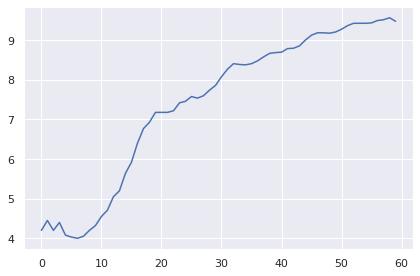

In [10]:
plt.plot(range(len(result)), result)
plt.tight_layout()
plt.show()

In [11]:
!apt-get install imagemagick

Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following package was automatically installed and is no longer required:
  libnvidia-common-460
Use 'apt autoremove' to remove it.
The following additional packages will be installed:
  fonts-droid-fallback fonts-noto-mono ghostscript gsfonts
  imagemagick-6-common imagemagick-6.q16 libcupsfilters1 libcupsimage2
  libdjvulibre-text libdjvulibre21 libgs9 libgs9-common libijs-0.35
  libjbig2dec0 liblqr-1-0 libmagickcore-6.q16-3 libmagickcore-6.q16-3-extra
  libmagickwand-6.q16-3 libnetpbm10 libwmf0.2-7 netpbm poppler-data
Suggested packages:
  fonts-noto ghostscript-x imagemagick-doc autotrace cups-bsd | lpr | lprng
  enscript gimp gnuplot grads hp2xx html2ps libwmf-bin mplayer povray radiance
  sane-utils texlive-base-bin transfig ufraw-batch inkscape libjxr-tools
  libwmf0.2-7-gtk poppler-utils fonts-japanese-mincho | fonts-ipafont-mincho
  fonts-japanese-gothic | fonts-ipafont-gothic fo

In [12]:
from matplotlib import animation

def display_frames_as_gif(frames):
    patch = plt.imshow(frames[0])
    plt.axis('off')
    def animate(i):
        patch.set_data(frames[i])
        
    anim = animation.FuncAnimation(plt.gcf(), animate, frames = len(frames), interval=5)
    anim.save('rnd_breakout_result.gif', writer='imagemagick', fps=30)

Total Reward : 12.00


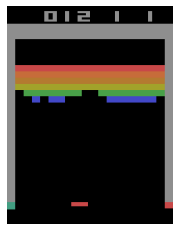

In [13]:
env = wrap_deepmind(make_atari(ENV_NAME))
s = np.array(env.reset())
total_reward = 0
frames = []
done_counter = 0

for t in range(10000):
    # Render into buffer. 
    frames.append(env.render(mode = 'rgb_array'))
    a, v, int_v, l = ppo.choose_action(np.expand_dims(s,axis=0))
    # take action and get next state
    s_, r, done, info = env.step(a)
    s_ = np.array(s_)
    total_reward += r
    if done:
        done_counter += 1
        if done_counter == 5:
            break
    s = s_
env.close()
print('Total Reward : %.2f'%total_reward)
anim = display_frames_as_gif(frames)

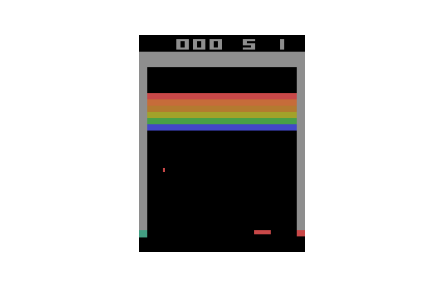

In [14]:
from IPython.display import Image
Image(open('rnd_breakout_result.gif','rb').read())

![alt text](./rnd_breakout_result.gif "segment")